In [1]:
from s04utils.modules.load.Timestamps import Timestamps
from s04utils.modules.load.BinnedTimestamps import BinnedTimestamps
from s04utils.modules.analyze import HMM_analysis as hmma

from bokeh.plotting import figure, show, output_notebook, curdoc
from matplotlib_inline.backend_inline import set_matplotlib_formats

import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import os
import glob


from sfHMM import sfHMM1
from sfHMM.gmm import GMMs


In [2]:
# Set quality for plt plots
set_matplotlib_formats('retina')

# Set output style for bokeh plots
#curdoc().theme = 'dark_minimal'
output_notebook()

Loading BokehJS ...

In [3]:
SOURCE_PATH = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/10uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_10uW_77K_circpol_031.h5'

In [4]:
# Load timestamps from file
ts_binned = BinnedTimestamps(path=SOURCE_PATH, bin_width=0.001)

In [5]:
hmma.create_bokeh_plot(ts_binned)

In [6]:
cutoff_pos, viterbi_steps = hmma.find_last_steps(ts_binned)
print(hmma.find_cutoffset(viterbi_steps))

Detector: detector_0
Unique: [ 3.22794521 19.26013478]
Counts: [31260  2115]

Detector: detector_0
Unique: [0. 1.]
Counts: [31260  2115]

---------------------------------
Detector: detector_1
Unique: [2.26290756 3.08045782]
Counts: [51937 23499]

Detector: detector_1
Unique: [0. 1.]
Counts: [51937 23499]

---------------------------------
Detector: detector_sum
Unique: [ 5.72813335 24.19913526]
Counts: [33780  1771]

Detector: detector_sum
Unique: [0. 1.]
Counts: [33780  1771]

---------------------------------
{'detector_0': 10, 'detector_1': 10, 'detector_sum': 10}


In [7]:
# Iterate over detectors in binned timestamps
for detector in ts_binned.as_dataframe.columns:
    gmms = GMMs(ts_binned.as_dataframe[detector][0:cutoff_pos[detector]], krange=(2, 6))
    gmms.fit()
    #gmms.show_aic_bic()
    #gmms.plot_all()
    gmms_opt_n = gmms.get_optimal(criterion="bic").n_components
    sf = sfHMM1(ts_binned.as_dataframe[detector][0:cutoff_pos[detector]], krange=(2, gmms_opt_n), model='p', name=detector).run_all(plot=False)
    hmma.plot_viterbi(ts_binned, sf)

In [18]:
import numpy as np

# Extracted features from real time traces
noise_std = 0.1  # Example noise standard deviation
amplitude_range = (0.5, 1.5)  # Example amplitude range
background_level = 0.2  # Example background level

# Parameters for synthetic time traces
num_time_steps = 100000
num_states = 3
transition_probabilities = np.array([[0.9, 0.05, 0.05], [0.1, 0.8, 0.1], [0.2, 0.3, 0.5]])
state_durations = [50, 100, 200]  # Example state durations

# Generate synthetic time traces
def generate_synthetic_trace():
    synthetic_trace = []
    state = np.random.choice(num_states)
    for duration in state_durations:
        state_values = np.random.normal(loc=background_level + state * 0.5, scale=noise_std, size=duration)
        synthetic_trace.extend(state_values)
        state = np.random.choice(num_states, p=transition_probabilities[state])
    return synthetic_trace[:num_time_steps]

# Generate multiple synthetic traces for training
num_synthetic_traces = 100000
synthetic_traces = [generate_synthetic_trace() for _ in range(num_synthetic_traces)]


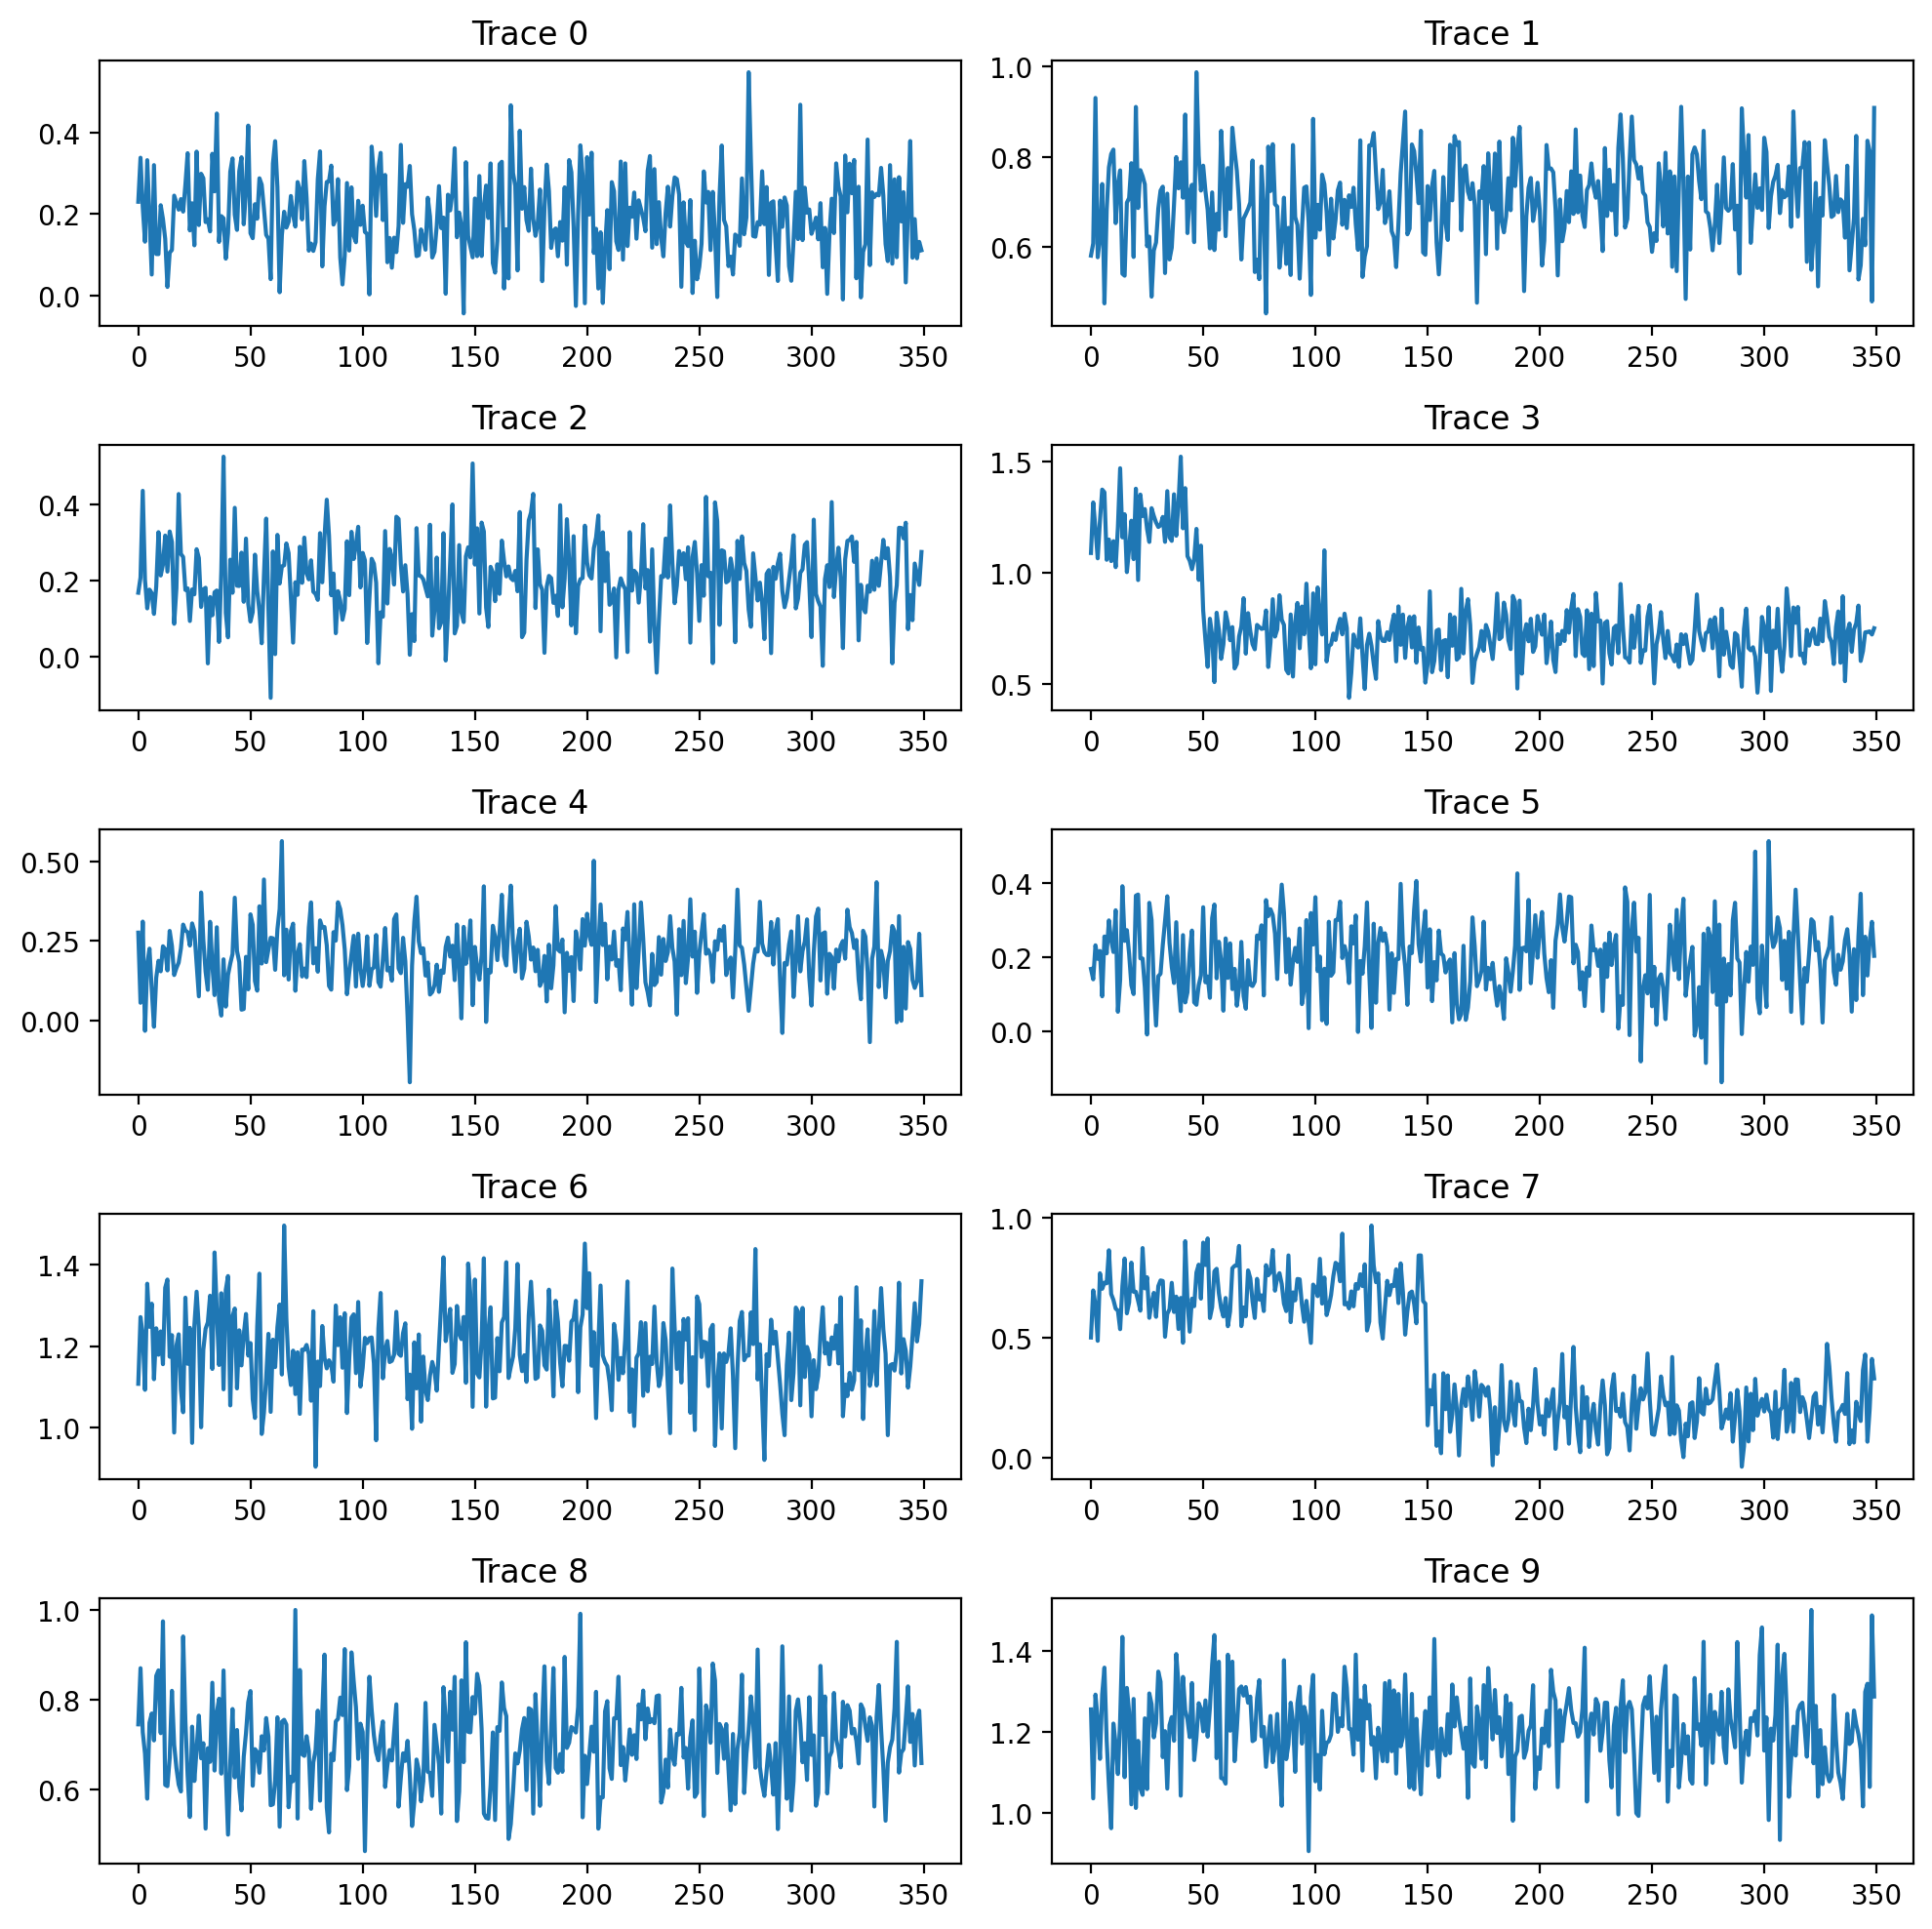

In [16]:
# Plot synthetic traces in individual subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.plot(synthetic_traces[i])
    ax.set_title(f"Trace {i}")
plt.tight_layout()
plt.show()



In [19]:
import numpy as np
import pandas as pd
import parmap
import pomegranate as pg
from retrying import RetryError, retry
from tqdm import tqdm

import lib.utils
from lib.utils import global_function
import warnings

warnings.filterwarnings("ignore")


def generate_traces(
    n_traces,
    state_means="random",
    random_k_states_max=4,
    min_state_diff=0.1,
    D_lifetime=500,
    A_lifetime=500,
    blink_prob=0.2,
    bleed_through=(0, 0.15),
    aa_mismatch=(-0.35, 0.35),
    trace_length=300,
    trans_prob=(0.0, 0.20),
    noise=(0.01, 0.30),
    trans_mat=None,
    au_scaling_factor=1,
    aggregation_prob=0.15,
    max_aggregate_size=20,
    null_fret_value=-1,
    acceptable_noise=0.25,
    S_range=(0.3, 0.7),
    scramble_prob=0.15,
    gamma_noise_prob=0.8,
    falloff_lifetime=500,
    falloff_prob=0.1,
    merge_labels=False,
    discard_unbleached=False,
    progressbar_callback=None,
    callback_every=1,
    return_matrix=False,
    run_headless_parallel=True,
    scramble_decouple_prob=0.9,
    reduce_memory=True,
    merge_state_labels=True,
):
    """
    Parameters
    ----------
    n_traces:
        Number of traces to generate
    state_means:
        Mean FRET value. Add multiple values for multiple states
    random_k_states_max:
        If state_means = "random", randomly selects at most k FRET states
    min_state_diff:
        If state_means = "random", randomly spaces states with a minimum
        distance
    D_lifetime:
        Lifetime of donor fluorophore, as drawn from exponential distribution.
        Set to None if fluorophore shouldn't bleach.
    A_lifetime:
        Lifetime of acceptor fluorophore, as drawn from exponential
        distribution. Set to None if fluorophore shouldn't bleach.
    blink_prob:
        Probability of observing photoblinking in a trace.
    bleed_through:
        Donor bleed-through into acceptor channel, as a fraction of the signal.
    aa_mismatch:
        Acceptor-only intensity mis-correspondence, as compared to DD+DA signal.
        Set as a value or range. A value e.g. 0.1 corresponds to 110% of the
        DD+DA signal. A range (-0.3, 0.3) corresponds to 70% to 130% of DD+DA
        signal.
    trace_length:
        Simulated recording length of traces. All traces will adhere to this
        length.
    trans_prob:
        Probability of transitioning from one state to another, given the
        transition probability matrix. This can also be overruled by a supplied
        transition matrix (see trans_mat parameter).
    noise:
        Noise added to a trace, as generated from a Normal(0, sigma)
        distribution. Sigma can be either a value or range.
    trans_mat:
        Transition matrix to be provided instead of the quick trans_prob
        parameter.
    au_scaling_factor:
        Arbitrary unit scaling factor after trace generation. Can be value or
        range.
    aggregation_prob:
        Probability of trace being an aggregate. Note that this locks the
        labelled molecule in a random, fixed FRET state.
    max_aggregate_size:
        Maximum number of labelled molecules in an aggregate.
    null_fret_value:
        Whether to set a specific value for the no-longer-viable *ground truth*
        FRET, e.g. -1, to easily locate it for downstream processing.
    acceptable_noise:
        Maximum acceptable noise level before trace is labelled as "noisy". If
        acceptable_noise is above the upper range of noise, no "noisy" traces
        will be generated.
    S_range:
        Range of accepted stoichiometry values for un-bleached frames, for
        scrambled or noisy traces only. Adjusting this may help the model better
        learn when a fluorophore is bleached
    scramble_prob:
        Probability that the trace will end up being scrambled. This stacks with
        aggregation.
    gamma_noise_prob:
        Probability to multiply centered Gamma(1, 0.11) to each frame's noise,
        to make the data appear less synthetic
    falloff_prob:
        Probability that the molecule will spontaneously fall off the surface
        (All intensities zero)
    falloff_lifetime:
        Exponential average lifetime if the molecule falls off the surface
    merge_labels:
        Merges (dynamic, static) and (aggregate, noisy, scrambled) to deal with
        binary labels only
    discard_unbleached:
        Whether to discard traces that don't fully bleach to background.
    callback_every:
        How often to callback to the progressbar
    progressbar_callback:
        Progressbar callback object
    return_matrix:
        Whether to return the transition matrices used to generate the traces
    run_headless_parallel:
        Runs the generator in parallel to massively speed up generation of
        traces. Does not work with GUI!
    scramble_decouple_prob:
        Probability for de-coupling fluorophores so that they aren't FRETing,
        if trace is "scrambled".
    reduce_memory:
        Reduces memory consumption of dataframe by keeping only intensities
        and labels
    merge_state_labels:
        Sets state labels to either 'static' or 'dynamic', instead of n-states.
        All labels above 5 (for more states) are thus set to 5
    """
    eps = 1e-16

    def _E(DD, DA):
        return DA / (DD + DA)

    def _S(DD, DA, AA):
        return (DD + DA) / (DD + DA + AA)

    def _DD(E):
        return 1 - E

    def _DA(DD, E):
        return -(DD * E) / (E - 1)

    def _AA(E):
        return np.ones(len(E))

    @retry
    def generate_state_means(min_acceptable_diff, k_states):
        """Returns random values and retries if they are too closely spaced"""
        states = np.random.uniform(0.01, 0.99, k_states)
        diffs = np.diff(sorted(states))
        if any(diffs < min_acceptable_diff):
            raise RetryError
        return states

    def generate_fret_states(kind, state_means, trans_mat, trans_prob):
        """Creates artificial FRET states"""
        if all(isinstance(s, float) for s in state_means):
            kind = "defined"

        rand_k_states = np.random.randint(1, random_k_states_max + 1)

        if kind == "aggregate":
            state_means = np.random.uniform(0, 1)
            k_states = 1
        elif kind == "random":
            k_states = (
                len(trans_mat) if trans_mat is not None else rand_k_states
            )
            state_means = generate_state_means(min_state_diff, k_states)
        else:
            if np.size(state_means) <= random_k_states_max:
                # Pick the same amount of k states as state means given
                k_states = np.size(state_means)
            else:
                # Pick no more than k_states_max from the state means (e.g.
                # given [0.1, 0.2, 0.3, 0.4, 0.5] use only
                # random_k_states_max of these)
                k_states = rand_k_states
                state_means = np.random.choice(
                    state_means, size=k_states, replace=False
                )

        if type(state_means) == float:
            dists = [pg.NormalDistribution(state_means, eps)]
        else:
            dists = [pg.NormalDistribution(m, eps) for m in state_means]

        starts = np.random.uniform(0, 1, size=k_states)
        starts /= starts.sum()

        # Generate arbitrary transition matrix
        if trans_mat is None:
            matrix = np.empty([k_states, k_states])
            matrix.fill(trans_prob)
            np.fill_diagonal(matrix, 1 - trans_prob)

            # Make sure that each row/column sums to exactly 1
            if trans_prob != 0:
                stay_prob = 1 - trans_prob
                remaining_prob = 1 - matrix.sum(axis=0)
                matrix[matrix == stay_prob] += remaining_prob
        else:
            if len(state_means) != len(trans_mat):
                raise ValueError(
                    "Number of FRET states ({0}) doesn't match transition matrix {1}x{1}".format(
                        len(state_means), len(trans_mat)
                    )
                )
            matrix = trans_mat

        model = pg.HiddenMarkovModel.from_matrix(
            matrix, distributions=dists, starts=starts
        )
        model.bake()

        final_matrix = model.dense_transition_matrix()[:k_states, :k_states]

        E_true = np.array(model.sample(n=1, length=trace_length))
        E_true = np.squeeze(E_true).round(4)
        return E_true, final_matrix

    def scramble(DD, DA, AA, classifications, label, decouple):
        """Scramble trace for model robustness"""
        if decouple:
            modify_trace = np.random.choice(("D", "A", "both"))
            # Either observe the wrong donor or acceptor
            if modify_trace == "D":
                DD[DD != 0] = 1
            elif modify_trace == "A":
                AA[AA != 0] = 1
                DA = AA
            # Otherwise, set to two static, non-interacting fluorophores
            else:
                DD[DD != 0] = 1
                AA[AA != 0] = 1
                DA = AA
        else:

            modify_trace = np.random.choice(("DD", "DA", "AA", "none"))
            if modify_trace == "AA":
                c = AA
            elif modify_trace == "DA":
                c = DA
            elif modify_trace == "DD":
                c = DD
            else:
                c = None

            if c is not None:
                # Create a sign wave and merge with trace
                c[c != 0] = 1
                sinwave = np.sin(
                    np.linspace(-10, np.random.randint(0, 1), len(DD))
                )
                sinwave[c == 0] = 0
                sinwave = sinwave ** np.random.randint(5, 10)
                c += sinwave * 0.4
                # Fix negatives
                c = np.abs(c)
                if modify_trace == "AA":
                    AA = c
                elif modify_trace == "DA":
                    DA = c
                elif modify_trace == "DD":
                    DD = c

            # Add dark state
            add_dark = np.random.choice(("add", "noadd"))
            if add_dark == "add":
                dark_state_start = np.random.randint(0, 40)
                dark_state_time = np.random.randint(10, 40)
                dark_state_end = dark_state_start + dark_state_time
                DD[dark_state_start:dark_state_end] = 0

            # Flip traces
            flip_trace = np.random.choice(("DD", "DA", "AA"))
            if flip_trace == "DD":
                DD = np.flip(DD)
            elif flip_trace == "DA":
                AA = np.flip(AA)
            elif flip_trace == "AA":
                DA = np.flip(DA)

            DD, DA, AA = [np.abs(x) for x in (DD, DA, AA)]

        label.fill(classifications["scramble"])
        for x in DD, DA, AA:
            label[x == 0] = classifications["bleached"]

        if not decouple:
            S_true = (DD + DA) / (DD + DA + AA)
            label[S_true < np.min(S_range)] = classifications["bleached"]
            label[S_true > np.max(S_range)] = classifications["bleached"]

        return DD, DA, AA, label

    @global_function
    def generate_single_trace(*args):
        """Function to generate a single trace"""
        (
            i,
            trans_prob,
            au_scaling_factor,
            noise,
            bleed_through,
            aa_mismatch,
            scramble_prob,
        ) = [np.array(arg) for arg in args]

        # Table to keep track of labels
        classifications = {
            "bleached": 0,
            "aggregate": 1,
            "noisy": 2,
            "scramble": 3,
            "1-state": 4,
            "2-state": 5,
            "3-state": 6,
            "4-state": 7,
            "5-state": 8,
        }

        name = [i.tolist()] * trace_length
        frames = np.arange(1, trace_length + 1, 1)

        if np.random.uniform(0, 1) < aggregation_prob:
            is_aggregated = True
            E_true, matrix = generate_fret_states(
                kind="aggregate",
                trans_mat=trans_mat,
                trans_prob=0,
                state_means=state_means,
            )
            if max_aggregate_size >= 2:
                aggregate_size = np.random.randint(2, max_aggregate_size + 1)
            else:
                raise ValueError("Can't have an aggregate of size less than 2")
            np.random.seed()
            n_pairs = np.random.poisson(aggregate_size)
            if n_pairs == 0:
                n_pairs = 2
        else:
            is_aggregated = False
            n_pairs = 1
            trans_prob = np.random.uniform(trans_prob.min(), trans_prob.max())
            E_true, matrix = generate_fret_states(
                kind=state_means,
                trans_mat=trans_mat,
                trans_prob=trans_prob,
                state_means=state_means,
            )

        DD_total, DA_total, AA_total = [], [], []
        first_bleach_all = []

        for j in range(n_pairs):
            np.random.seed()
            if D_lifetime is not None:
                bleach_D = int(np.ceil(np.random.exponential(D_lifetime)))
            else:
                bleach_D = None

            if A_lifetime is not None:
                bleach_A = int(np.ceil(np.random.exponential(A_lifetime)))
            else:
                bleach_A = None

            first_bleach = lib.utils.min_none((bleach_D, bleach_A))

            # To keep track of multiple fluorophores for aggregates
            first_bleach_all.append(first_bleach)

            # Calculate from underlying E
            DD = _DD(E_true)
            DA = _DA(DD, E_true)
            AA = _AA(E_true)

            # Randomly remove either single donor or acceptor from aggregate
            if np.random.uniform(0, 1) < 0.5 and j == 1 and n_pairs == 2:
                if np.random.choice(("D", "A")) == "D":
                    DD -= 1
                else:
                    DA -= 1
                    AA -= 1

            # In case AA intensity doesn't correspond exactly to donor
            # experimentally (S will be off)
            AA += np.random.uniform(aa_mismatch.min(), aa_mismatch.max())

            # If donor bleaches first
            if first_bleach is not None:
                if first_bleach == bleach_D:
                    # Donor bleaches
                    DD[bleach_D:] = 0
                    # DA goes to zero because no energy is transferred
                    DA[bleach_D:] = 0

                # If acceptor bleaches first
                elif first_bleach == bleach_A:
                    # Donor is 1 when there's no acceptor
                    DD[bleach_A:bleach_D] = 1
                    if is_aggregated and n_pairs <= 2:
                        # Sudden spike for small aggregates to mimic
                        # observations
                        spike_len = np.min((np.random.randint(2, 10), bleach_D))
                        DD[bleach_A : bleach_A + spike_len] = 2

                # No matter what, zero each signal after its own bleaching
                if bleach_D is not None:
                    DD[bleach_D:] = 0
                if bleach_A is not None:
                    DA[bleach_A:] = 0
                    AA[bleach_A:] = 0

            # Append to total fluorophore intensity per channel
            DD_total.append(DD)
            DA_total.append(DA)
            AA_total.append(AA)

        DD, DA, AA = [np.sum(x, axis=0) for x in (DD_total, DA_total, AA_total)]

        # Initialize -1 label for whole trace
        label = np.zeros(trace_length)
        label.fill(-1)

        # Calculate when a channel is bleached. For aggregates, it's when a
        # fluorophore channel hits 0 from bleaching (because 100% FRET not
        # considered possible)
        if is_aggregated:
            if np.random.uniform(0, 1) < falloff_prob:
                if falloff_lifetime is not None:
                    falloff_frame = int(
                        np.ceil(np.random.exponential(falloff_lifetime))
                    )
                else:
                    falloff_frame = None
                DD[falloff_frame:] = 0
                DA[falloff_frame:] = 0
                AA[falloff_frame:] = 0

            # First bleaching for
            bleach_DD_all = np.argmax(DD == 0)
            bleach_DA_all = np.argmax(DA == 0)
            bleach_AA_all = np.argmax(AA == 0)

            # Find first bleaching overall
            first_bleach_all = lib.utils.min_none(
                (bleach_DD_all, bleach_DA_all, bleach_AA_all)
            )
            if first_bleach_all == 0:
                first_bleach_all = None
            label.fill(classifications["aggregate"])
        else:
            # Else simply check whether DD or DA bleaches first from lifetimes
            first_bleach_all = lib.utils.min_none(first_bleach_all)

        # Save unblinked fluorophores to calculate E_true
        DD_no_blink, DA_no_blink = DD.copy(), DA.copy()

        # No blinking in aggregates (excessive/complicated)
        if not is_aggregated and np.random.uniform(0, 1) < blink_prob:
            blink_start = np.random.randint(1, trace_length)
            blink_time = np.random.randint(1, 15)

            # Blink either donor or acceptor
            if np.random.uniform(0, 1) < 0.5:
                DD[blink_start : (blink_start + blink_time)] = 0
                DA[blink_start : (blink_start + blink_time)] = 0
            else:
                DA[blink_start : (blink_start + blink_time)] = 0
                AA[blink_start : (blink_start + blink_time)] = 0

        if first_bleach_all is not None:
            label[first_bleach_all:] = classifications["bleached"]
            E_true[first_bleach_all:] = null_fret_value

        for x in (DD, DA, AA):
            # Bleached points get label 0
            label[x == 0] = classifications["bleached"]

        if is_aggregated:
            first_bleach_all = np.argmin(label)
            if first_bleach_all == 0:
                first_bleach_all = None

        # Scramble trace, but only if contains 1 or 2 pairs (diminishing
        # effect otherwise)
        is_scrambled = False
        if np.random.uniform(0, 1) < scramble_prob and n_pairs <= 2:
            is_decoupled = (
                True
                if np.random.uniform(0, 1) < scramble_decouple_prob
                else False
            )
            DD, DA, AA, label = scramble(
                DD=DD,
                DA=DA,
                AA=AA,
                classifications=classifications,
                label=label,
                decouple=is_decoupled,
            )
            is_scrambled = True

        # Add donor bleed-through
        DD_bleed = np.random.uniform(bleed_through.min(), bleed_through.max())
        DA[DD != 0] += DD_bleed

        # Re-adjust E_true to match offset caused by correction factors
        # so technically it's not the true, corrected FRET, but actually the
        # un-noised
        E_true[E_true != null_fret_value] = _E(
            DD_no_blink[E_true != null_fret_value],
            DA_no_blink[E_true != null_fret_value],
        )

        # Add gaussian noise
        noise = np.random.uniform(noise.min(), noise.max())
        x = [s + np.random.normal(0, noise, len(s)) for s in (DD, DA, AA)]

        # Add centered gamma noise
        if np.random.uniform(0, 1) < gamma_noise_prob:
            for signal in x:
                gnoise = np.random.gamma(1, noise * 1.1, len(signal))
                signal += gnoise
                signal -= np.mean(gnoise)

        # Scale trace to AU units and calculate observed E and S as one would
        # in real experiments
        au_scaling_factor = np.random.uniform(
            au_scaling_factor.min(), au_scaling_factor.max()
        )
        DD, DA, AA = [s * au_scaling_factor for s in x]

        E_obs = _E(DD, DA)
        S_obs = _S(DD, DA, AA)

        # FRET from fluorophores that aren't bleached
        E_unbleached = E_obs[:first_bleach_all]
        E_unbleached_true = E_true[:first_bleach_all]

        # Count actually observed states, because a slow system might not
        # transition between all states in the observation window
        unique_states = np.unique(
            E_unbleached_true[E_unbleached_true != null_fret_value]
        )

        # Calculate noise level for each FRET state, and check if it
        # surpasses the limit
        is_noisy = False
        if not any((is_aggregated, is_scrambled)):
            for state in unique_states:
                noise_level = np.std(E_unbleached[E_unbleached_true == state])
                if noise_level > acceptable_noise:
                    label[
                        label != classifications["bleached"]
                    ] = classifications["noisy"]
                    is_noisy = True

        # For all FRET traces, assign the number of states observed
        if not any((is_noisy, is_aggregated, is_scrambled)):
            for i in range(5):
                k_states = i + 1
                if len(unique_states) == k_states:
                    label[
                        label != classifications["bleached"]
                    ] = classifications["{}-state".format(k_states)]

        # Bad traces don't contain FRET
        if any((is_noisy, is_aggregated, is_scrambled)):
            E_true.fill(-1)

        # Ensure that any bad stoichiometry values are correctly set to bleached
        if any((is_noisy, is_scrambled)):
            E_true[label == classifications["bleached"]] = -1

        # Everything that isn't FRET is 0, and FRET is 1
        if merge_labels:
            label[label <= 3] = 0
            label[label >= 4] = 1

        if discard_unbleached and label[-1] != classifications["bleached"]:
            return pd.DataFrame()

        try:
            if label[0] in [5, 6, 7, 8]:
                min_diff = np.min(np.diff(np.unique(E_unbleached_true)))
            else:
                min_diff = -1
        except ValueError:
            min_diff = -1

        bg = np.zeros_like(DD)

        # Columns pre-fixed with underscore contain metadata, and only the
        # first value should be used (repeated because table structure)
        if reduce_memory:
            trace = pd.DataFrame(
                {
                    "D-Dexc-rw": DD,
                    "A-Dexc-rw": DA,
                    "A-Aexc-rw": AA,
                    "name": name,
                    "label": label,
                }
            )
        else:
            trace = pd.DataFrame(
                {
                    "D-Dexc-rw": DD,
                    "A-Dexc-rw": DA,
                    "A-Aexc-rw": AA,
                    "D-Dexc-bg": bg,
                    "A-Dexc-bg": bg,
                    "A-Aexc-bg": bg,
                    "E": E_obs,
                    "E_true": E_true,
                    "S": S_obs,
                    "frame": frames,
                    "name": name,
                    "label": label,
                    "_bleaches_at": np.array(first_bleach_all).repeat(
                        trace_length
                    ),
                    "_noise_level": np.array(noise).repeat(trace_length),
                    "_min_state_diff": np.array(min_diff).repeat(trace_length),
                    "_max_n_classes": np.array(
                        len(classifications.keys())
                    ).repeat(trace_length),
                }
            )
        trace.replace([np.inf, -np.inf, np.nan], -1, inplace=True)
        trace.fillna(method="pad", inplace=True)
        pbar.update()

        return trace, matrix

    processes = range(n_traces)
    n_processes = 8 if run_headless_parallel else 1

    if run_headless_parallel:
    # Running in parallel seems to get the progress slightly wrong
        pbar = tqdm(total=(n_traces / n_processes), smoothing=1)
    else:
        pbar = tqdm(n_traces)

    if run_headless_parallel:
        traces_matrices = parmap.map(
            generate_single_trace,
            processes,
            trans_prob,
            au_scaling_factor,
            noise,
            bleed_through,
            aa_mismatch,
            scramble_prob,
            pm_parallel=True,
            pm_processes=n_processes,
        )

        traces, matrices = zip(*traces_matrices)
    else:
        traces = []
        matrices = []
        for i in processes:
            t, m = generate_single_trace(
                i,
                trans_prob,
                au_scaling_factor,
                noise,
                bleed_through,
                aa_mismatch,
                scramble_prob,
            )

            traces.append(t)
            matrices.append(m)

            if progressbar_callback is not None and (i % callback_every) == 0:
                progressbar_callback.increment()

    traces = (
        pd.concat(traces, ignore_index=True, copy=False, sort=False)
        if len(traces) > 1
        else traces[0]
    )
    matrices = np.array(matrices)
    pbar.close()

    if merge_state_labels:
        # 2, 3, 4, 5 states will all have the same label,
        # considered "dynamic"
        traces["label"][traces["label"] > 5] = 5

    if return_matrix:
        return traces, matrices
    else:
        return traces

ModuleNotFoundError: No module named 'parmap'